In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='talk', style='ticks',
        color_codes=True, rc={'legend.frameon': False})

%matplotlib inline

In [4]:
energies = pd.read_csv('../20220512_icsd_and_battery/predicted_energies.csv.gz', index_col=0)
volumes = pd.read_csv('../20220512_icsd_and_battery_vol/predicted_volumes.csv.gz', index_col=0)

In [38]:
energies['energy_err'] = (energies['energyperatom'] - energies['energy_predicted']).abs()
energies.groupby(['set', 'type']).energy_err.mean().unstack().round(3)

type,icsd,relax,vol
set,,,
test,0.037,0.027,0.049
test_composition,0.060,0.050,0.070
valid,0.035,0.027,0.050


In [39]:
energies.groupby(['set', 'type']).energy_err.count().unstack()

type,icsd,relax,vol
set,,,
test,8128,33311,29445
test_composition,136,870,732
valid,8127,33311,29446


In [16]:
volumes['vol_err'] = (volumes['volperatom'] - volumes['volume_predicted']).abs()
volumes.groupby(['set', 'type']).vol_err.mean().unstack().round(3)

type,icsd,relax,vol
set,,,
test,0.294,0.484,0.305
test_composition,0.822,0.587,0.435
valid,0.309,0.477,0.310


In [40]:
volumes.groupby(['set', 'type']).vol_err.count().unstack()

type,icsd,relax,vol
set,,,
test,8128,33249,25713
test_composition,136,994,840
valid,8127,33249,25714


In [19]:
import datashader as ds
from datashader.mpl_ext import dsshow, alpha_colormap

In [31]:
volumes.type = volumes.type.astype('category')
energies.type = energies.type.astype('category')

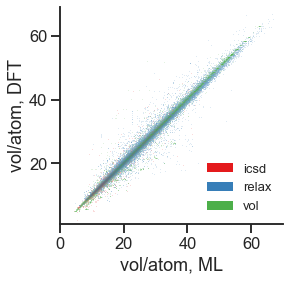

In [32]:
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111, aspect='equal', adjustable='datalim')

artist = dsshow(volumes,
       ds.Point('volume_predicted', 'volperatom'),
       ds.count_cat('type'),       
       cmap='Blues', norm='eq_hist', aspect='equal',
       x_range=(0, 70), y_range=(0, 70), ax=ax)

ax.set_xlabel('vol/atom, ML')
ax.set_ylabel('vol/atom, DFT')
ax.legend(handles=artist.get_legend_elements(), fontsize=13, loc='lower right')
sns.despine()

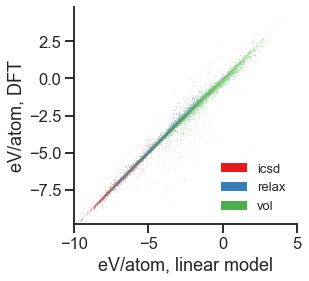

In [35]:
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111, aspect='equal', adjustable='datalim')

artist = dsshow(energies,
       ds.Point('energy_predicted', 'energyperatom'),
       ds.count_cat('type'),       
       cmap='Blues', norm='eq_hist', aspect='equal',
       x_range=(-10, 5), y_range=(-10, 5), ax=ax)

ax.set_xlabel('eV/atom, linear model')
ax.set_ylabel('eV/atom, DFT')
ax.legend(handles=artist.get_legend_elements(), fontsize=13, loc='lower right')
sns.despine()